# Functional Encryption - Classification and information leakage

 
### Encryption time!

As we explained at the beginning of these tutorials, our quadratic network $Q$ is compatible with the Quadratic FE scheme detailed in [this paper](https://eprint.iacr.org/2018/206.pdf). But for this to be really effective, we need to convert the network weights to integers. We could use the fixed precision abstraction from the [PySyft](https://github.com/OpenMined/PySyft/) library which is perfect in this PyTorch context, but actually as we are not allowed truncation, we really need to work with real integers so it wouldn't be the most practical: therefore, we will write our own `fix_precision` function.

In addition, note that all weights don't need the same precision as they have different amplitudes. We will assess how to scale the inputs and how to cap layers values (which are now integers) to have the smallest outputs possible, as without truncation the values will grow fast. We need the smallest output values possible beacuse we need to apply the discrete log to decode the values. Our objective is to to have an output which can be represented with $n$ bits, with $n$ sufficiently small to have all the exponent values in RAM memory so that the discrete log can be trivially implemented.

# 9 Converting the model to integers


Load torch and syft packages

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch

In [3]:
from math import log2, ceil

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import collateral

In [4]:
PRIVATE_OUTPUT_SIZE = 4
N_CHARS = 10
N_FONTS = 2

Let's load the quadratic model that we saved in Part 8! _Be sure that the path and file name match._

In [5]:
class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [6]:
path = '../data/models/quadconvnet_part8.pt'
model = CollateralNet()
results = {}

model.load_state_dict(torch.load(path))
model.eval()

CollateralNet(
  (proj1): Linear(in_features=784, out_features=40, bias=True)
  (diag1): Linear(in_features=40, out_features=4, bias=False)
  (lin1): Linear(in_features=4, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=10, bias=True)
  (jct): Linear(in_features=4, out_features=784, bias=True)
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)

Here is a function to analyse a tensor distribution

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def print_hist(data):
    x = data.view(-1).abs()
    # the histogram of the data
    n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('Weight amplitude')
    plt.ylabel('Probability')
    plt.title('Weight amplitude distribution')
    #plt.axis([40, 160, 0, 0.01])
    plt.grid(True)
    plt.show()
    
    
def print_data(data):
    ax = sns.heatmap(data, linewidth=0.5)
    plt.show()

And our function to convert tensors to integers with a precision parameter, and vice-versa

In [8]:
def fix_precision(tensor, precision_bits, rm_outlier_frac=100, parameter=True):
    tensor = (tensor * 2**precision_bits).long()
    max_value = max(
        np.abs(np.percentile(tensor, rm_outlier_frac)),
        np.abs(np.percentile(tensor, 100 - rm_outlier_frac))
    )
    cp_tensor = 1 * tensor
    tensor = tensor.clamp(min=-max_value, max=max_value)
    if parameter:
        return nn.Parameter(tensor, requires_grad=False)
    else:
        return tensor
    
def float_precision(tensor, precision_bits):
    tensor = tensor.float()/2**precision_bits
    return tensor

In [9]:
class Parser:
    """Parameters for the testing"""
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 10

In [10]:
args = Parser()

data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
test_target = test_target_char
test_dataset = learn.build_tensor_dataset(test_data, test_target)
test_loader = utils.DataLoader(
    test_dataset,
    batch_size=args.test_batch_size, shuffle=True
)

Training set 60000 items
Testing set  10000 items


Our test function modifies the data first in the encrypted setting (ie values are integers) and then converts back the output to float to run the public part of the net used to predict digits.

In [11]:
def test(model, test_loader, prec):
    data_prec, proj_prec, diag_prec = prec 
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Private Part
            data = fix_precision(data, data_prec, parameter=False)
            private_output = model.quad(data)
            # Public Part
            output = float_precision(private_output, sum(prec))
            output = model.char_net(output)

            pred = output.argmax(1, keepdim=True)  # get the index of the max log-probability

            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, len(test_loader.dataset), acc))
    
    return acc

Given a precision setting, this returns the accuracy of the main task and the maximum number of bits needed to store the output.

In [12]:
def test_compression(prec, rm_outlier_frac=100, show_distrib=False):
    model = CollateralNet()
    model.load_state_dict(torch.load(path))
    model.eval()

    data_prec, proj_prec, diag_prec = prec 
    
    if show_distrib and False:
        print_hist(model.proj1.weight.detach())
        print_hist(model.proj1.bias.detach())
        print_hist(model.diag1.weight.detach())
        
    # Convert the model
    model.proj1.weight = fix_precision(model.proj1.weight, proj_prec, rm_outlier_frac)
    model.proj1.bias = fix_precision(model.proj1.bias, proj_prec + data_prec, rm_outlier_frac)
    model.diag1.weight = fix_precision(model.diag1.weight, diag_prec, rm_outlier_frac)
        
    if show_distrib:
        print_hist(model.proj1.weight)
        print_hist(model.proj1.bias)
        print_hist(model.diag1.weight)
    
    data_sample = fix_precision(test_dataset[0][0], data_prec, parameter=False)
    n_bits = (
        ceil(log2(torch.max(data_sample))) * 2 +
        ceil(log2(max(
            torch.max(model.proj1.bias / 2 ** data_prec),
            torch.max(model.proj1.weight)
        ) * 2)) * 2 + 
        ceil(log2(torch.max(model.diag1.weight) * 2))   
    )
    print("approx size", n_bits)
        
    test(model, test_loader, prec)
    
    return model, data_prec
    

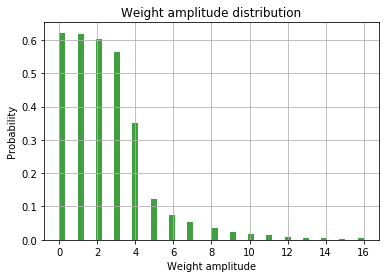

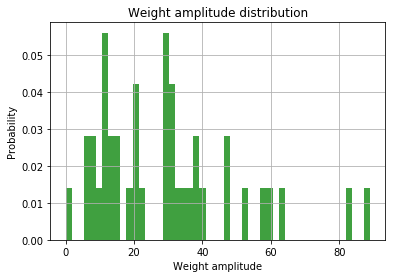

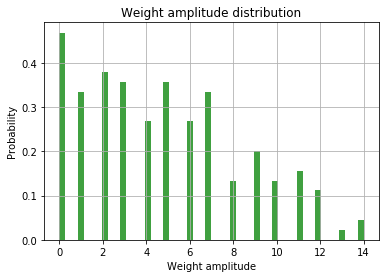

approx size 27

Test set: Accuracy: 9736/10000 (97.36%)



In [20]:
prec=(3, 7, 5) # (3, 7, 5)
data_prec, proj_prec, diag_prec = prec 
model, data_prec = test_compression(prec=prec, rm_outlier_frac=99.9, show_distrib=True)

So, as you observe, we keep a 98% accuracy with weight and data inputs integers between 0 and 16 (so on 4 bits)!.
Experiments show that the total output is around 27 bits long, so we'll construct a discrete log algorithm which can work for output up to 30 bits long (so < 10^9)


Let's save this model now

In [21]:
saving_path = '/Users/tryffel/code/reading-in-the-dark/mnist/objects/ml_models/quad_conv.pt'
torch.save(model.state_dict(), saving_path)

## Collateral efficiency

We do a quick check to see if the collateral accuracy has changed, for example on the K-NN. You can observe that it hasn't.

In [22]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': N_CHARS, 'font': N_FONTS}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot

In [23]:
train_dataset, test_dataset = collateral.data.get_datasets(None, None)
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

data_prec, proj_prec, diag_prec = prec 
train_input = fix_precision(train_input, data_prec, parameter=False)
test_input = fix_precision(test_input, data_prec, parameter=False)

train_input = model.quad(train_input)
test_input = model.quad(test_input)

train_input = float_precision(train_input, sum(prec))
test_input = float_precision(test_input, sum(prec))

train_input = train_input.detach().numpy()
test_input = test_input.detach().numpy()

train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

Training set 60000 items
Testing set  10000 items


In [24]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [25]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

In [26]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

0.6345


## Conclusion

Now that we know how to efficiently convert our model into integers, let's sync with the work of the paper to use their implementation of Functional Encryption, available [here](https://github.com/edufoursans/reading-in-the-dark)!

Note that because we kept our output really low (<200M), we can reimplement the BabyStepGiantStep algorithm of the repo with small giant steps (=1000) and store all of them in a simple pickle file. Therefore, we show in practice that the discrete log computation drops from 11s to 20ms!

**Export the model for FE** To get the model to the right format, you should convert the proj1 and diag1 weights to lists and then follow the intructions in "Supplementary Appendix B - Export model to Reading In the Dark.ipynb". 

We do a similar approach with a model robust model in part 9 bis, and also assess how the CNN against which the resistance was built behave when the quadratic private network is converted to integers. Go check it out!